In [32]:
# Author: Bowen Huang
# Created in May 23
#Import necessary modules
import pandas as pd
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def F2Cfun(f_list):
    "Return list in Celsius degree given Fahrenheit degree"
    return [(f -32)*5/9 for f in f_list]
def Cfm2Kgs(v_list):
    "Return list in Kg/s given Cubic-feet/min(water mass)"
    return [0.47*v for v in v_list]
def AvgLst(v_list, dT):
    return [sum(v_list[i:i+dT])/dT for i in range(0,len(v_list),dT)]
def RMSEp(y_true, y_pred):
    # Normalized RMSE, normalized by (max - min) or mean
    y_t = np.array(y_true)
    y_p = np.array(y_pred)
#     return np.sqrt(np.mean(np.square((y_t - y_p)))) 
    mask = (y_t >= 0.001)
    return np.sqrt(np.mean(np.square((y_t[mask] - y_p[mask])/np.max(y_t[mask])))) #np.max(y_t)-np.min(y_t)

def linReg(Xtrain, ytrain, Xtest, ytest, Xtest_m, Xtest_tdis): #linear regression model
    flag = True # Print output or not
    global modelflag
    def predict_acc(Xt):
        yt = []
        for t in range(len(Xt)):
            Tz = reg.predict([Xt[t]])[0]
            if t < len(Xt)-1:
                Xt[t+1][0] = Tz
                Xt[t+1][2] = Xtest_m[t+1]*(Xtest_tdis[t] - Tz)
            yt.append(Tz)
        return np.array(yt)
    
    #performs linear regression for training data
    reg = LinearRegression().fit(Xtrain, ytrain)
    if flag:
        #outputs r^2 scores
        print('Linear regression scores: ', reg.score(Xtrain, ytrain), reg.score(Xtest,ytest))
    
    #predicts output for training data based on regression
    yfit = reg.predict(Xtrain)
    
    err_train = yfit-ytrain #calculates error for training data
    RMSE_train=RMSEp(ytrain,yfit)#np.sqrt(mean_squared_error(ytrain,yfit)) #calculates RMSE for training
    
    #predicts output for test data based on regression
    ######### Compute 1 day multiple days averaged(check if significant change)
    coeff = np.concatenate((reg.coef_,[reg.intercept_]))
    
    if modelflag == 1:
        yresults = predict_acc(Xtest)
        ylabel = 'Zone temperature ($^\circ$C)'
    elif modelflag == 2:
        yresults = reg.predict(Xtest)
        ylabel = 'Mass flow rate (kg/s)'
    
    if flag:
        for i in range(len(coeff)):
            print("{:.16f}".format(coeff[i]))
    
    err_test = yresults-ytest #error for test data
    if modelflag == 1:
        RMSE_test = np.sqrt(mean_squared_error(ytest,yresults))
    elif modelflag == 2:
        RMSE_test= RMSEp(ytest,yresults)#np.sqrt(mean_squared_error(ytest,yresults)) #RMSE for test data
    
    if flag:
        #printts relevant error values
        print('\nRMSE: ', RMSE_train, RMSE_test)
        print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
        print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
        print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
    
        #initializes arrays for plotting
        t1 = np.linspace(1, 21, len(ytrain)) #array of days for training data
        t2 = np.linspace(1, 7, len(ytest)) #array of days for test data

        #plots linear regression training results
        plt.figure(1)
        plt.plot(t1, ytrain, 'o', mfc ='none', label='training data')
        plt.plot(t1, yfit, label='linear regression results')
        plt.xlabel('Day')
        plt.ylabel(ylabel)
        plt.title('Linear regression training results')
        plt.legend()


        #plots linear regression training % error
        plt.figure(2)
        plt.plot(t1, 100*err_train/ytrain, label='linear regression results')
        plt.xlabel('Day')
        plt.ylabel('% Error')
        plt.title('Linear regression training results')
        plt.legend()

        #plots linear regression test results
        plt.figure(3)
        plt.plot(t2, ytest, 'o', mfc ='none', label='test data')
        plt.plot(t2, yresults, label='linear regression results')
        plt.title('Linear regression test results')
        plt.xlabel('Day')
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()
        #plots linear regression test % error
        plt.figure(4)
        plt.plot(t2, 100*err_test/ytest, label='linear regression results')
        plt.title('Linear regression test results')
        plt.xlabel('Day')
        plt.ylabel('% Error')
        plt.legend()
    
    return yresults, coeff, RMSE_test

In [2]:
rawdata = pd.read_csv('building1.csv')
RoomName = ['002','004','100','102','104','105','107','108', \
            '112','116','118','119','120','121','123A','123B',\
            '127A','127B','129','133','136','142','143','150']
# RoomName = RoomName[1:9]
# 002 004 100 121 missing lighting power
N = len(RoomName)
print("Total number of rooms:",N)

Total number of rooms: 24


In [3]:
Ttpower = rawdata['WholeBuildingPower']
Ts  = rawdata['Date'].tolist()
TOA = rawdata['OurdoorAirTemperature'].tolist()
TOA = F2Cfun(TOA)
Tzon = []
Tset = []
Mdot = []
Pfan = []
for z in range(N):
    rName = RoomName[z]
    Tzon.append(rawdata['ZoneTemperature_{0}'.format(rName)].tolist()) # unit in Fahrenheit degree
    Tset.append(rawdata['ZoneCoolingTemperatureSetpoint_{0}'.format(rName)].tolist()) # unit in Fahrenheit degree
    Mdot.append(rawdata['SupplyAirFlow_{0}'.format(rName)].tolist()) # unit in cubic-feet/min
#     Pfan.append(rawdata['WholeBuildingPower'] - rawdata['LightingPower_{0}'.format(rName)])
Tzon = [F2Cfun(flist) for flist in Tzon]
Tset = [F2Cfun(flist) for flist in Tset]
Mdot = [Cfm2Kgs(vlist) for vlist in Mdot]
Tdis1 = rawdata['DischargeAirTemperature_112'].tolist()
Tdis1 = F2Cfun(Tdis1)
Tdis2 = rawdata['DischargeAirTemperature_116'].tolist()
Tdis1 = F2Cfun(Tdis2)

Total Number of Rooms is 24
Linear regression scores:  0.9768790929165192 0.9772987734042515
-4.0811346456112894
-0.2649409385890301
-104.0912169180363662
2832.4495024925627149

RMSE:  0.1079296448131599 0.10627233912431304

Max % error:  inf inf

Mean % error:  nan nan

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
/Users/huan926/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


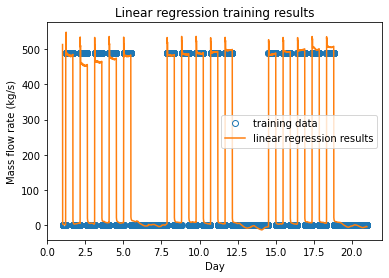

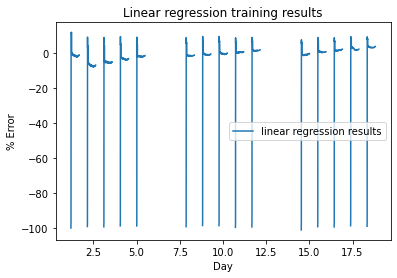

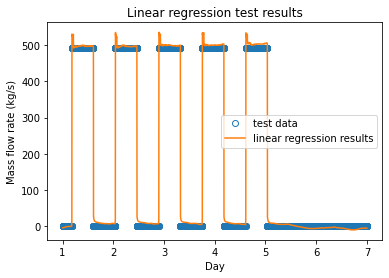

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.9767002497269255 0.977372741037683
-7.2826661529286678
-0.1104340223920920
-138.9872164162742649
3812.6875521147871950

RMSE:  0.10898171066313264 0.10658347637856318

Max % error:  inf inf

Mean % error:  nan nan

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
/Users/huan926/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


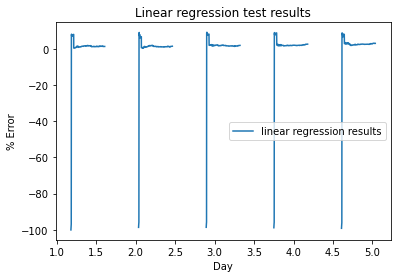

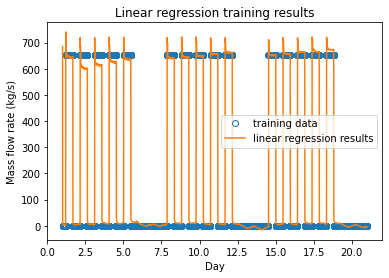

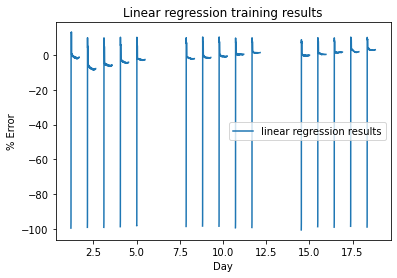

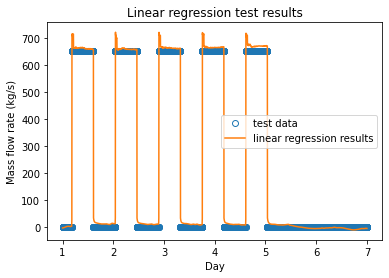

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.23789652400652128 -0.0017813961068036122
1.7092886280838548
0.0849714620796288
-1.9182431303016614
27.7934372724219365

RMSE:  0.1005479470284963 0.08539224061857434

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


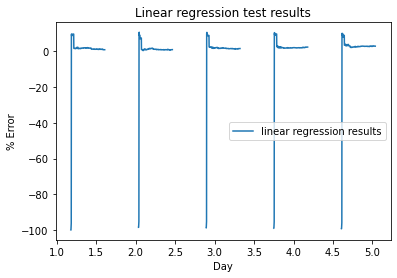

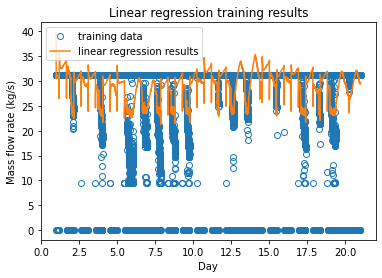

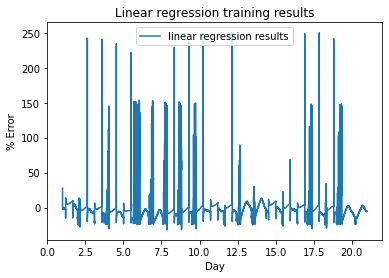

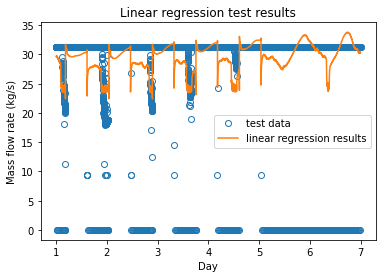

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))


Linear regression scores:  0.5808689294711145 0.46903572418356276
-7.3074200351706686
6.0859817688842224
-26.9809444270150358
910.7655439697546171

RMSE:  0.1519098572987076 0.1764451830220504

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


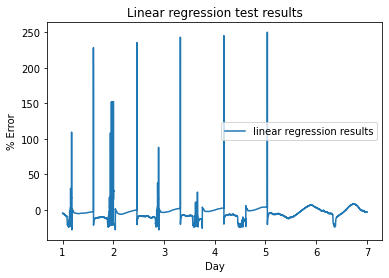

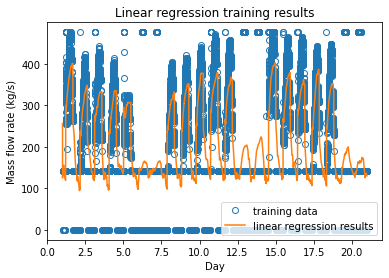

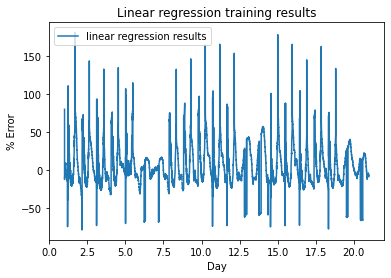

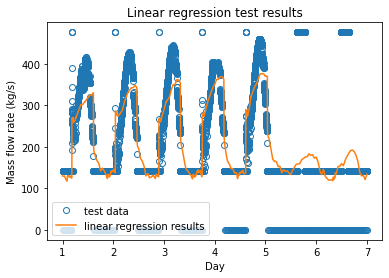

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.8514077105398399 0.8906961269589485
0.7022107025282484
-0.1178623873315615
-5.9207054239022447
151.6050921598832701

RMSE:  0.09515371270668307 0.07976498992527244

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


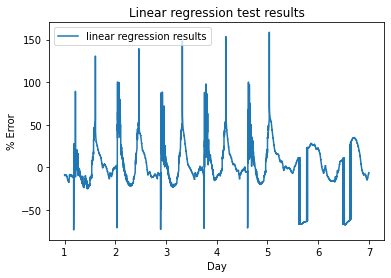

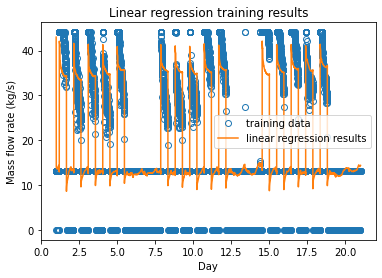

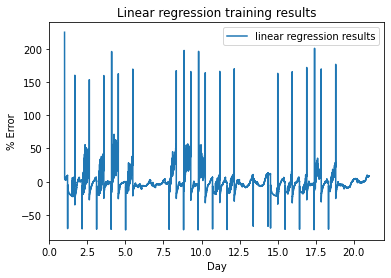

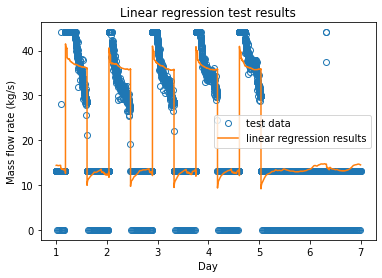

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.5832412744642461 0.4988402462585455
-3.3285722175302599
6.7151936620266257
-23.1439836552206408
688.8139832178237612

RMSE:  0.15388242476420602 0.16981399361465632

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


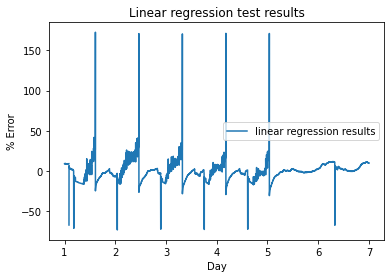

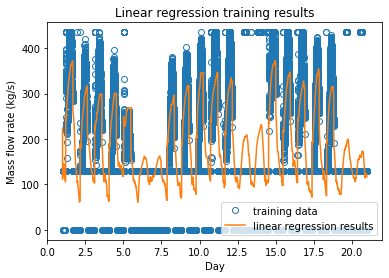

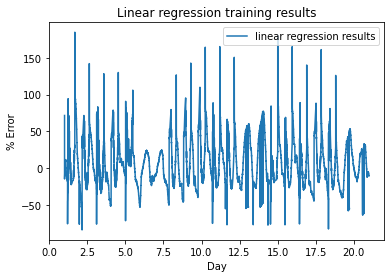

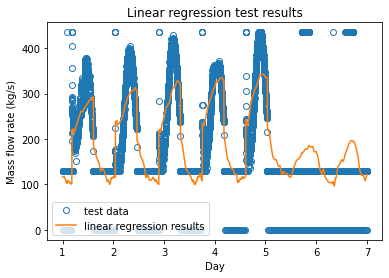

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.8094879566694463 0.8518854030295907
-0.4319662898523854
0.2305753956248720
-5.4623950725101524
165.3511434289661679

RMSE:  0.0956223887687151 0.07782807578834543

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


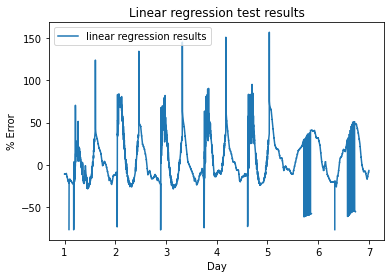

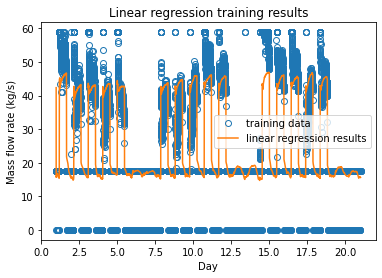

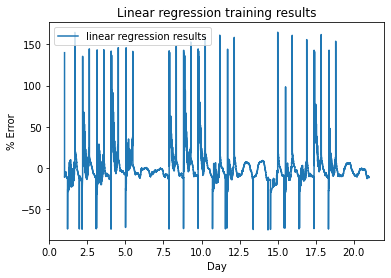

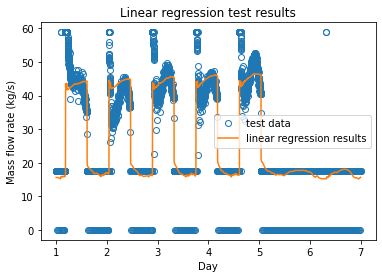

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.46049207929438596 0.405620478739252
6.4368455978947337
0.2757087549447823
-31.8503372349894818
748.7072522353814747

RMSE:  0.2278647295890145 0.23919890954481357

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


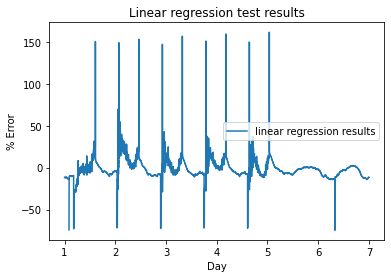

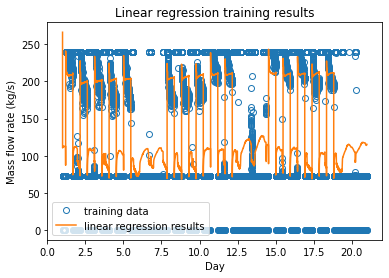

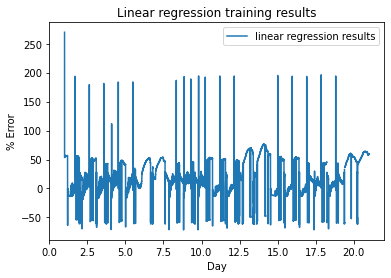

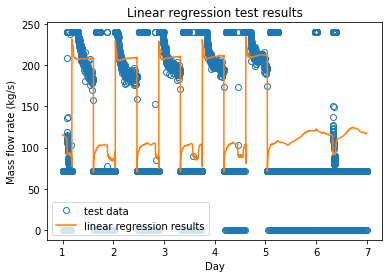

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.4740596117230038 0.13214423481607873
12.1892537554765106
1.2432163666359948
-21.3574070136111374
310.3996343174121648

RMSE:  0.13604333685925507 0.13552980175803483

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


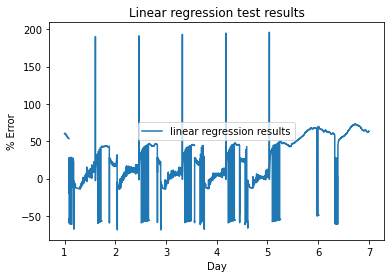

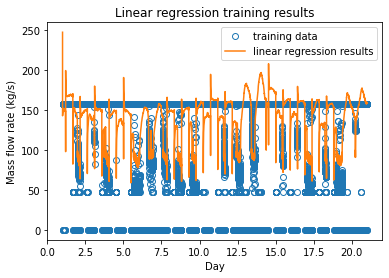

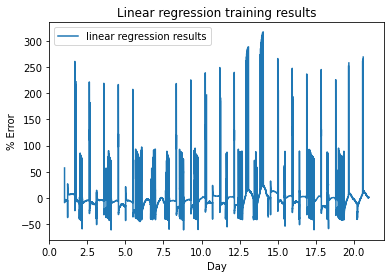

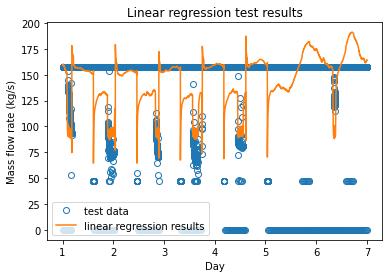

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))


Linear regression scores:  0.7758402754505829 0.836951143111061
0.5167633786244050
-0.0839080530659374
-3.4361674297317024
87.1765564084232238

RMSE:  0.10408404150334426 0.08466231906723003

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


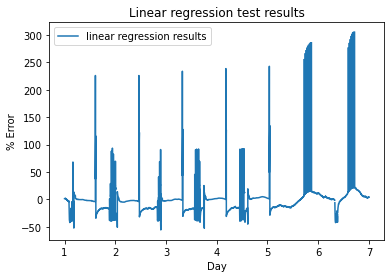

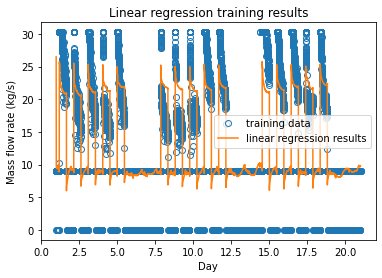

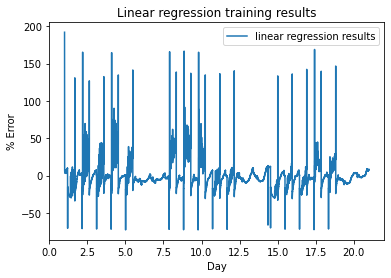

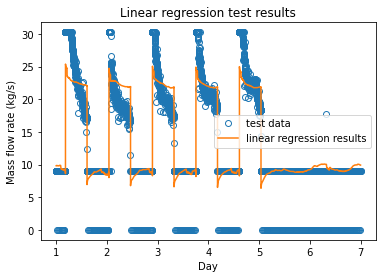

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.8390398608658636 0.8641934995069724
1.2328428656610082
-0.2860489249123377
-21.2059324760071419
579.8836453673893629

RMSE:  0.09215853156719492 0.08698129712396434

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


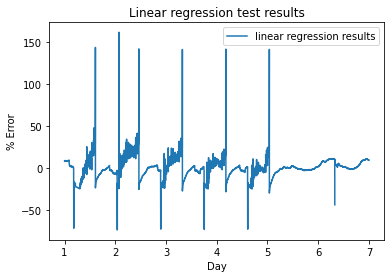

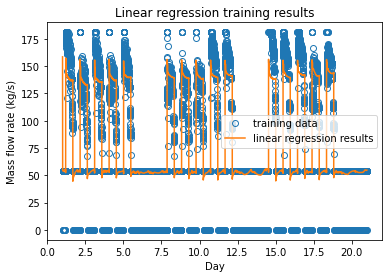

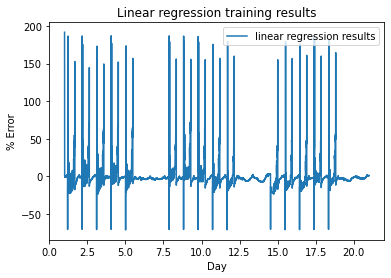

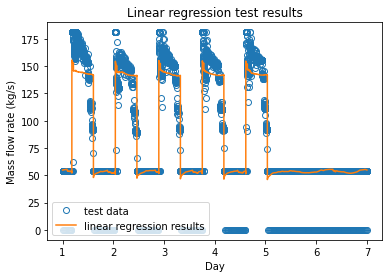

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.8607123633646006 0.8873077724445133
0.6056249991995865
-0.1349245218103097
-4.2596264146398743
108.3526484730927137

RMSE:  0.08237674966047709 0.07545035487968346

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


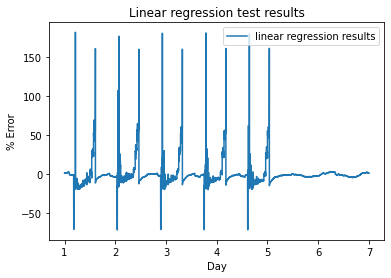

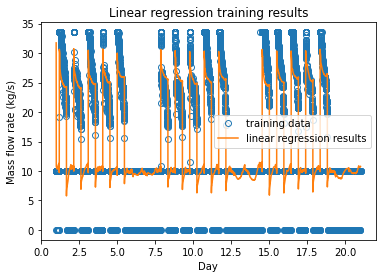

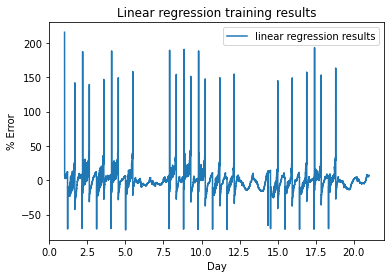

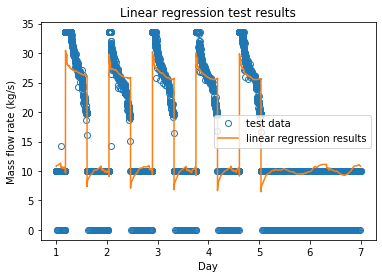

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.8429701244926205 0.8808109481956352
0.7930952046018444
-0.1527625713726297
-4.4608957511459639
109.6020985671048606

RMSE:  0.08892810948792454 0.07725824078876599

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


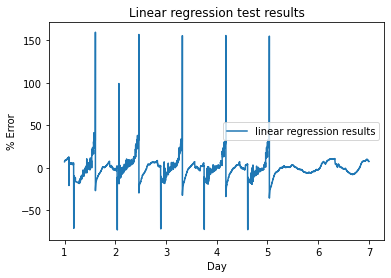

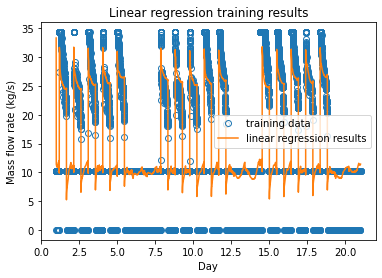

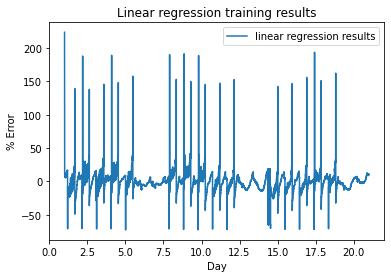

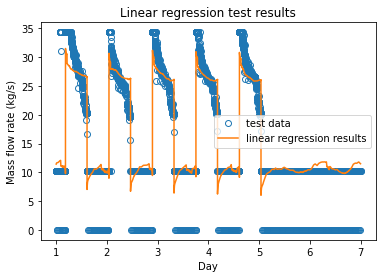

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.8491417096151567 0.8865752020628401
0.0317529879413625
0.0572043203871746
-10.6086710745826593
304.1590347747546730

RMSE:  0.0783948319256136 0.06699742183329815

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


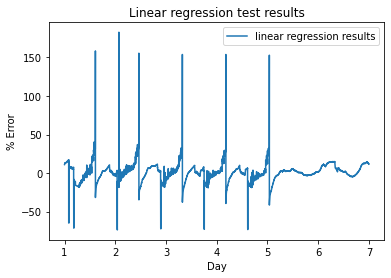

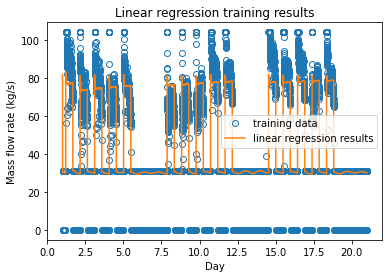

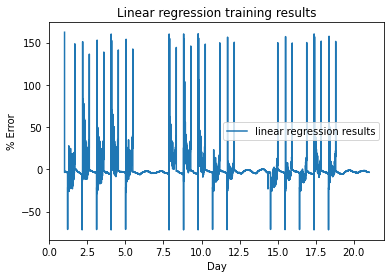

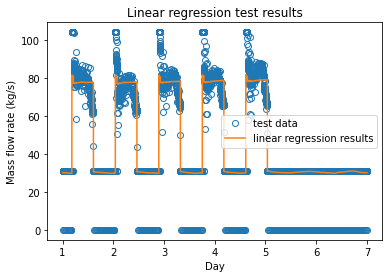

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.47418224325317593 0.43040723718650664
21.6013102782127540
-2.6961652350957581
-35.9010524279175485
527.2697026082275897

RMSE:  0.1784073921028668 0.19366223608793465

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


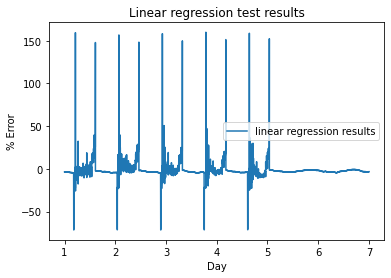

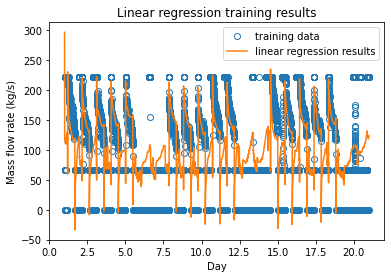

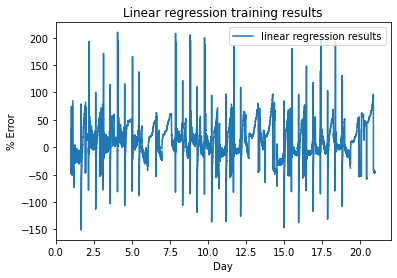

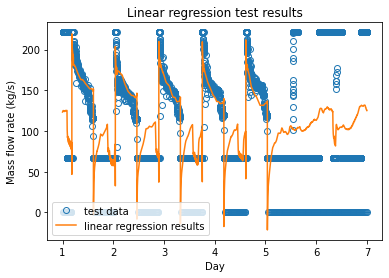

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.49824351809755374 0.448844705437091
20.3353546427550391
-2.5476856990801995
-36.3235126700629110
568.0967474210600585

RMSE:  0.1746152343263941 0.19297047744814208

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


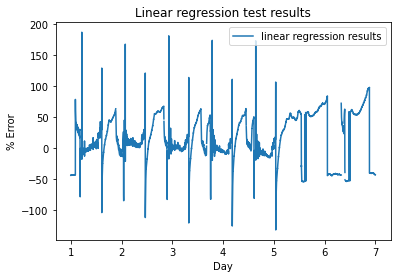

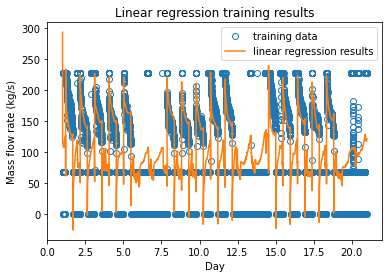

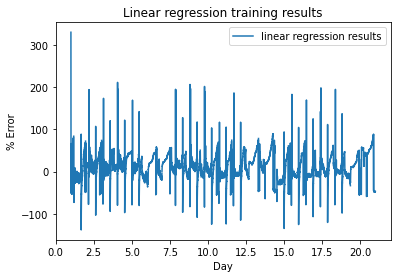

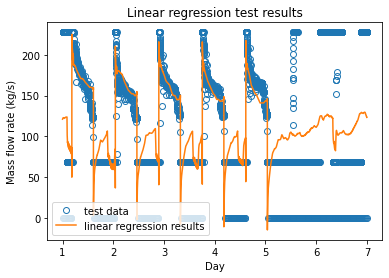

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.7777999944207026 0.8352706829483248
-4.4097606501821094
1.5958152023738370
-43.7397621192089900
1395.6773920668174469

RMSE:  0.0737474237525519 0.059867532898926386

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


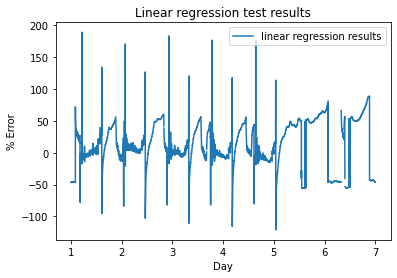

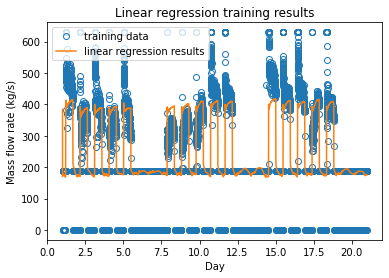

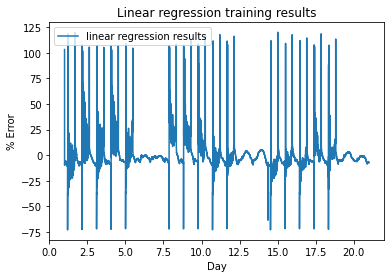

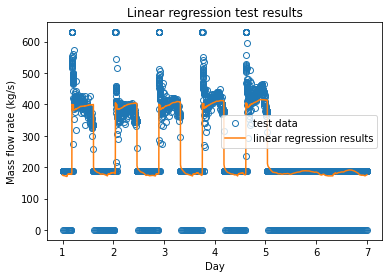

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.27090630630051304 0.3191774850826422
32.1416985854238959
5.9644944986954807
-78.0289308993716446
1550.9672379998974066

RMSE:  0.22608077720832867 0.20285027248644566

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


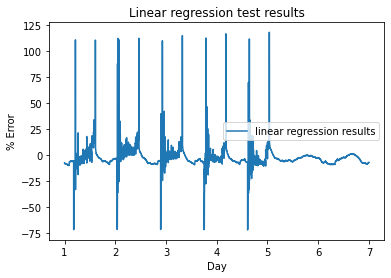

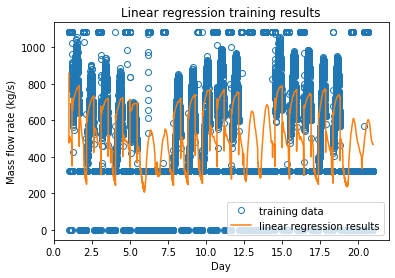

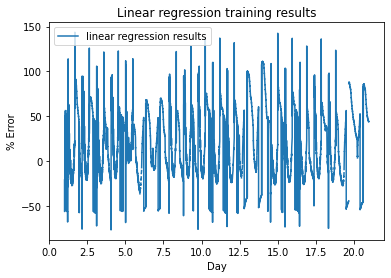

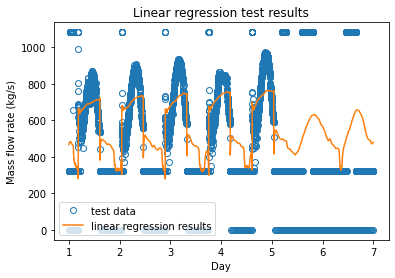

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.7293878755506333 0.8435295533271429
5.3791088214278071
-0.7547562577479823
-15.9700405360309006
333.8112401576771049

RMSE:  0.11958875030420908 0.08167288169626451

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


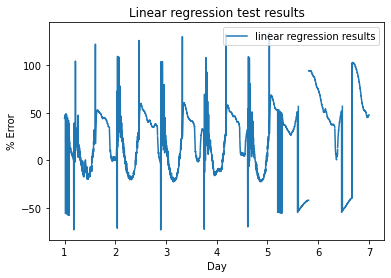

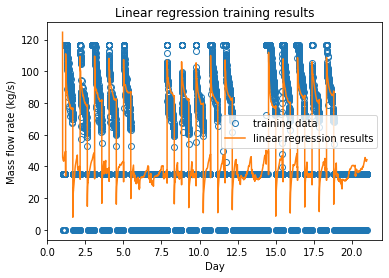

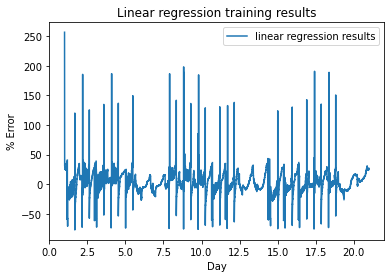

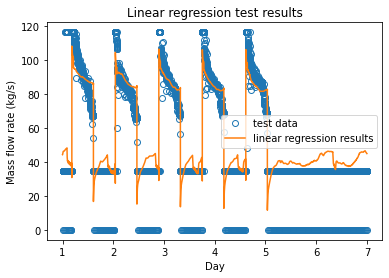

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))


Linear regression scores:  0.5072411790913258 0.39183036289733486
8.0602101877476819
1.2622226713758740
-0.7262468984610913
-130.0533675252821411

RMSE:  0.20563291617321094 0.22552487601639049

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


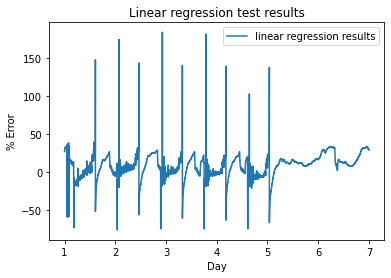

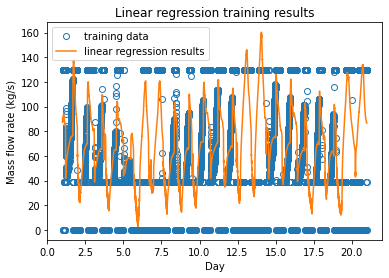

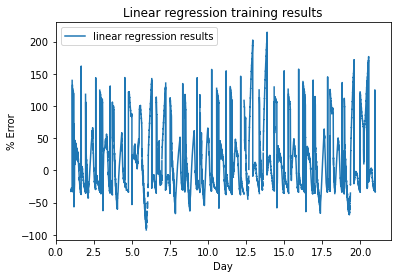

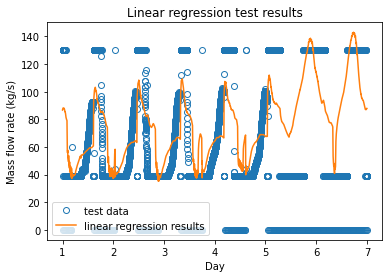

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
/Users/huan926/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.549568739384972 0.40774297790232295
65.1018596859410223
11.3568038048814195
-20.8412136090803450
-960.3052509804915644

RMSE:  0.25175611060581415 0.2862115232067137

Max % error:  inf inf

Mean % error:  nan inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


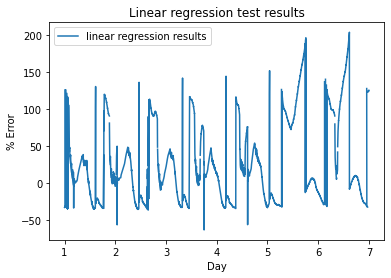

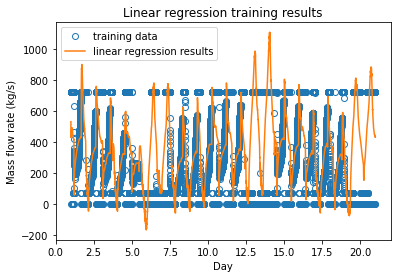

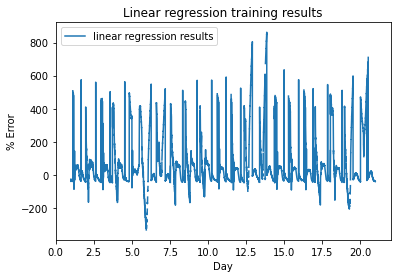

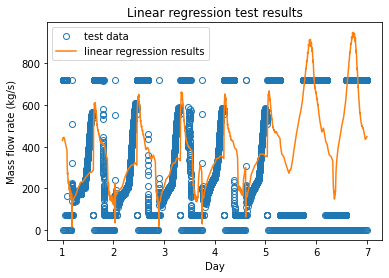

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


Linear regression scores:  0.5826227737855841 0.5246116598187048
6.5750048987513230
2.4692474512518836
0.5662672616163713
-140.6772145899925590

RMSE:  0.18553024501624224 0.19727441246733196

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


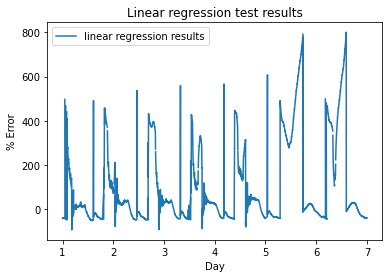

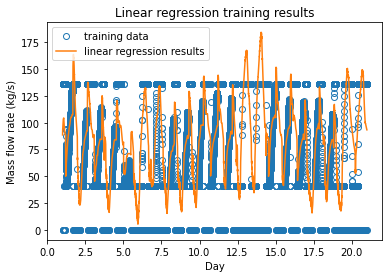

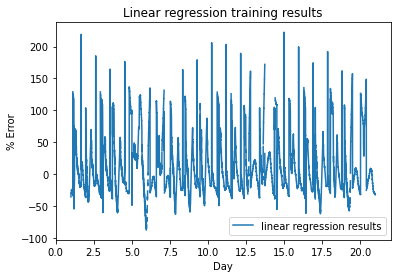

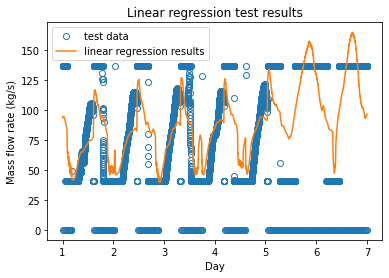

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.4241943171792907 0.37137755850921406
3.2453429978564388
1.2295393427443273
-12.2574727925808755
270.0791004979463423

RMSE:  0.20522444712403473 0.2092045357216393

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


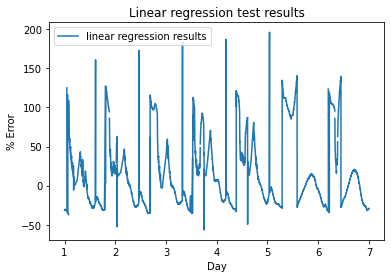

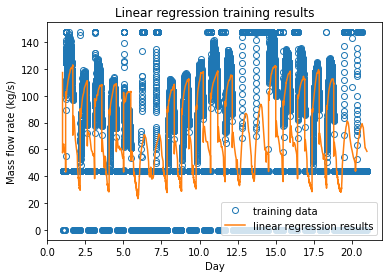

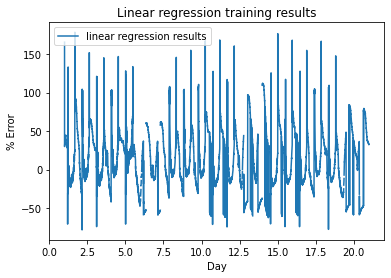

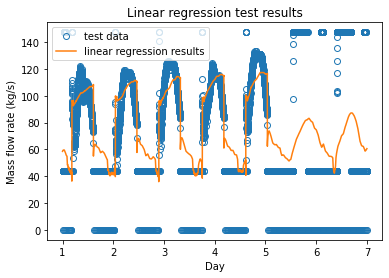

<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')
<ipython-input-32-c69cd976d51c>:78: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMax % error: ', 100*max(np.abs(err_train/ytrain)), 100*max(np.abs(err_test/ytest)))
<ipython-input-32-c69cd976d51c>:79: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean % error: ', 100*np.mean(err_train/ytrain), 100*np.mean(err_test/ytest))
<ipython-input-32-c69cd976d51c>:80: RuntimeWarning: divide by zero encountered in true_divide
  print('\nMean mag % error: ', 100*np.mean(np.abs(err_train/ytrain)), 100*np.mean(np.abs(err_test/ytest)))


Linear regression scores:  0.786847218125114 0.835678401841839
3.3016852245994781
-0.5887314597079395
-42.0358031357495960
1154.2107267829640023

RMSE:  0.08665683107144795 0.07445686549350715

Max % error:  inf inf

Mean % error:  inf inf

Mean mag % error:  inf inf


<ipython-input-32-c69cd976d51c>:98: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t1, 100*err_train/ytrain, label='linear regression results')


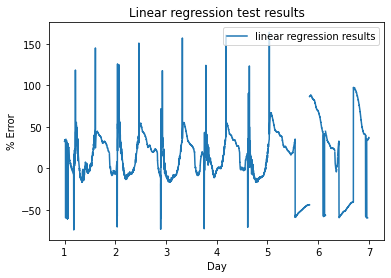

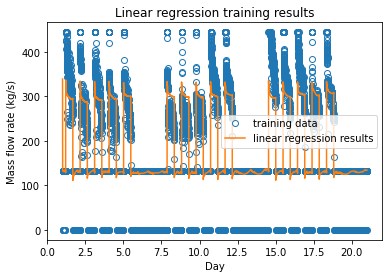

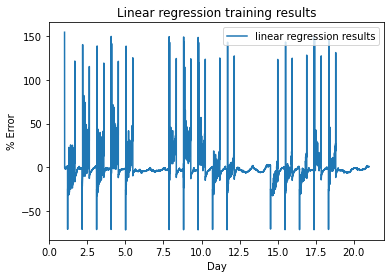

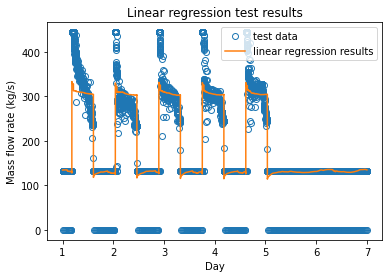

Zone Temperature prediciton RMSE is 1.4923777597826852e-15
Mass flow prediciton RMSE is 0.13716142737461923
Zone Temperature prediciton RMSE is 1.4923777597826852e-15


<ipython-input-32-c69cd976d51c>:115: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(t2, 100*err_test/ytest, label='linear regression results')


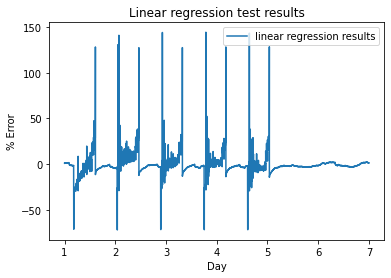

In [33]:
%matplotlib inline 
#qt

Ttotal = 40320
##########################################################
## Set time resolution to 1 or 60(min)
##########################################################
dT = 1# Time interval
##########################################################
## Set model option 1 or 2
##########################################################
modelflag = 2
print('Total Number of Rooms is',N)
RMSE_Ttt = 0
RMSE_Mtt = 0
debugflag = 0 # No printout in linear regression

T0 = []
# Tstart = [1,4,10,24,35,78,86,123,137]
Tstart = [137]
Tstart = [tt+12 for tt in Tstart]
## Start Time from 0:00, 12:00pm 
for tt in Tstart:
    T0.append(int(24*(60/dT)*21+tt*(60/dT)))
Tlen = 24*int(60/dT)
Ttest = []
for t0 in T0:
    Ttest.append(list(range(t0,t0+Tlen)))
RMSE_Ttot = 0
for Tind in range(len(Tstart)):
    for Zid in range(N):
        Mdot_z= Mdot[Zid]
        Tset_z= Tset[Zid]
        Tzon_z= Tzon[Zid]
        Tdis  = [12.8]*len(Tdis1) # Constant discharge temperature 12.8 Degree Celsius

        Tzonm = [sum(Tzon_z[i:i+dT])/dT for i in range(0,len(Tzon_z),dT)]
        TOAm  = [sum(TOA[i:i+dT])/dT for i in range(0,len(TOA),dT)]
        Mdotm = [sum(Mdot_z[i:i+dT])/dT for i in range(0,len(Mdot_z),dT)]
        Tsetm = [sum(Tset_z[i:i+dT])/dT for i in range(0,len(Tset_z),dT)]
        Tdism = [sum(Tdis[i:i+dT])/dT for i in range(0,len(Tdis),dT)]

        Xtrain = []
        Xtest = []
        Xtest_m = []
        Xtest_tdis = []
        # Model 1: Tz' = a1*Tz + a2*Toa + a3*mdot(Tdis - Tz) + a4
        # Model 2: mdot = a1*Tz + a2*Toa + a3*Tset + a4
        for t in range(1,int(Ttotal/dT)):
            if (t < 24*(60/dT)*21): # Use first 3 weeks as training data
                if modelflag == 1:
                    Xtrain.append([Tzonm[t-1], TOAm[t-1], Mdotm[t]*(Tdism[t-1] - Tzonm[t-1])])
                elif modelflag == 2:
                    Xtrain.append([Tzonm[t-1], TOAm[t-1], Tsetm[t-1]])
            else:
                if modelflag == 1:
                    if t in Ttest[Tind]: # Manually change the Ttest then average RMSE_T
                        Xtest.append([Tzonm[t-1], TOAm[t-1], Mdotm[t]*(Tdism[t-1] - Tzonm[t-1])])
                elif modelflag == 2:
                    Xtest.append([Tzonm[t-1], TOAm[t-1], Tsetm[t-1]])
                Xtest_m.append(Mdotm[t])
                Xtest_tdis.append(Tdism[t-1])
        if modelflag == 1:
            ym = Tzonm
        elif modelflag == 2:
            ym = Mdotm
        ytrain= ym[1:(len(Xtrain)+1)]
        ytest = ym[(len(Xtrain)+1):len(Xtrain)+len(Xtest)+1]

        yrlr, coeff, RMSE_test = linReg(Xtrain, ytrain, Xtest, ytest, Xtest_m, Xtest_tdis)
        if modelflag == 1:
            RMSE_Ttt = RMSE_Ttt + RMSE_test
    #         Xt_np = np.array(Xtest)
    #         Xt1_np = np.array(Xtest_T)
    #         Ypred_np = np.array(yrlr)
    #         Mz_pred = (Ypred_np - coeff[0]*Xt_np[:,0] - coeff[1]*Xt_np[:,1]-coeff[3])/coeff[2]/Xt1_np
            RMSE_Mtt = 0 #RMSE_Mtt + RMSEp(Xt_np[:,2]/Xt1_np,Mz_pred)#np.sqrt(mean_squared_error(Xt_np[:,2]/Xt1_np,Mz_pred))
        elif modelflag == 2:
            RMSE_Mtt = RMSE_Mtt + RMSE_test
            Xt_np = np.array(Xtest)
            Ypred_np = np.array(yrlr)
            Tz_pred = (Ypred_np - coeff[1]*Xt_np[:,1] - coeff[2]*Xt_np[:,2]-coeff[3])/coeff[0]
            RMSE_Ttt = RMSE_Ttt + RMSEp(Xt_np[:,0],Tz_pred)#np.sqrt(mean_squared_error(Xt_np[:,0],Tz_pred))
    #     RMSE_Ptt = RMSE_Ptt + RMSE_P

    RMSE_Ttt = RMSE_Ttt/N # Average over all rooms
    RMSE_Mtt = RMSE_Mtt/N
    RMSE_Ttot = RMSE_Ttot + RMSE_Ttt
    print("Zone Temperature prediciton RMSE is",RMSE_Ttt)
    print("Mass flow prediciton RMSE is",RMSE_Mtt)
RMSE_Ttot = RMSE_Ttot/len(Tstart)
print("Zone Temperature prediciton RMSE is",RMSE_Ttot)

|dT= 1|              |
|---------|---------|
|Time period 1:|    2.036119848146391|
|Time period 2:|   3.3266630454612582|
|Time period 3:|    3.5430330659625793|
|Time period 4:|    1.7355829560805711|
|Time period 5:|    3.8228522465531594|
|Time period 6:|    3.069715525288094|
|Time period 7:|    3.5215623197062196|
|Time period 8:|    2.5448713493573774|
|Time period 9:|    7.247195672668298|
|Time period 10:|    2.5190519429581557|
|Average: | |

|dT= 60   |         |
|---------|---------|
|Time period 1:|    1.0775063688227344|
|Time period 2:|    1.516429913271723|
|Time period 3:|    2.397786684591065|
|Time period 4:|    1.005062503422326|
|Time period 5:|    2.382451326587289|
|Time period 6:|    2.3608151169382148|
|Time period 7:|    2.013007142159245|
|Time period 8:|    1.3671103166714278|
|Time period 9:|    2.032621355378222|
|Time period 10:|    1.0870957111098922|
|Average: | |

In [ ]:
# # Training the Electric power consumption model
# Mtot1 = [0]*len(Mdot_z)
# Mtot2 = [0]*len(Mdot_z)
# Mtot3 = [0]*len(Mdot_z)
# Tr = 

# for Zid in range(N):
#     Mdot_z= Mdot[Zid]
#     Mtot1 = [Mtot1[t] + Mdot_z[t] for t in range(len(Mtot1))
#     Mtot2 = [Mtot2[t] + Mdot_z[t]**2 for t in range(len(Mtot2))
#     Mtot3 = [Mtot3[t] + Mdot_z[t]**3 for t in range(len(Mtot3))
#     Tset_z= Tset[Zid]
#     Tzon_z= Tzon[Zid]
#     Tdis  = [12.8]*len(Tdis1) # Constant discharge temperature 12.8 Degree Celsius

In [ ]:
# import numpy as np
# from sklearn.linear_model import LinearRegression
# X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# # y = 1 * x_0 + 2 * x_1 + 3
# y = np.dot(X, np.array([1, 2])) + 3
# reg = LinearRegression().fit(X, y)
# reg.score(X, y)
d# reg.coef_

# reg.intercept_

# yy = reg.predict([X[-1]])
# aa = False
# print(aa)
a = [1,2,4,5,10,11,-1]
a = np.array(a)
mask = (a<=1)
b = a[mask]
print(b)